In [1]:
%%time

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go



import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split

#utility
from tqdm.notebook import tqdm
directory = 'data/chest_xray/'

Wall time: 3.59 s


In [11]:
## Check GPU

print(tensorflow.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Loading Dataset

In [2]:
train_df = glob.glob('data/chest_xray/train/**/*.jpeg')
train_df[:5]

['data/chest_xray/train\\NORMAL\\IM-0115-0001.jpeg',
 'data/chest_xray/train\\NORMAL\\IM-0117-0001.jpeg',
 'data/chest_xray/train\\NORMAL\\IM-0119-0001.jpeg',
 'data/chest_xray/train\\NORMAL\\IM-0122-0001.jpeg',
 'data/chest_xray/train\\NORMAL\\IM-0125-0001.jpeg']

In [3]:
test_df = glob.glob('data/chest_xray/test/**/*.jpeg')
test_df[:5]

['data/chest_xray/test\\NORMAL\\IM-0001-0001.jpeg',
 'data/chest_xray/test\\NORMAL\\IM-0003-0001.jpeg',
 'data/chest_xray/test\\NORMAL\\IM-0005-0001.jpeg',
 'data/chest_xray/test\\NORMAL\\IM-0006-0001.jpeg',
 'data/chest_xray/test\\NORMAL\\IM-0007-0001.jpeg']

In [4]:
validation_df = glob.glob('data/chest_xray/val/**/*.jpeg')
validation_df[:5]

['data/chest_xray/val\\NORMAL\\NORMAL2-IM-1427-0001.jpeg',
 'data/chest_xray/val\\NORMAL\\NORMAL2-IM-1430-0001.jpeg',
 'data/chest_xray/val\\NORMAL\\NORMAL2-IM-1431-0001.jpeg',
 'data/chest_xray/val\\NORMAL\\NORMAL2-IM-1436-0001.jpeg',
 'data/chest_xray/val\\NORMAL\\NORMAL2-IM-1437-0001.jpeg']

## Data Exploration

In [5]:
print("Training dataset contains {} images.".format(len(train_df)))
print("Testing dataset contains {} images.".format(len(test_df)))
print("Validation dataset contains {} images.".format(len(validation_df)))

Training dataset contains 5216 images.
Testing dataset contains 624 images.
Validation dataset contains 16 images.


## Data Visualization

NORMAL


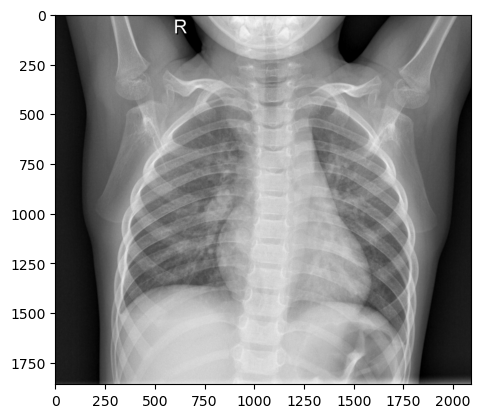

In [6]:
normal_lung_image = load_img("data/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
print("NORMAL")
plt.imshow(normal_lung_image)
plt.show()

Pneumonia


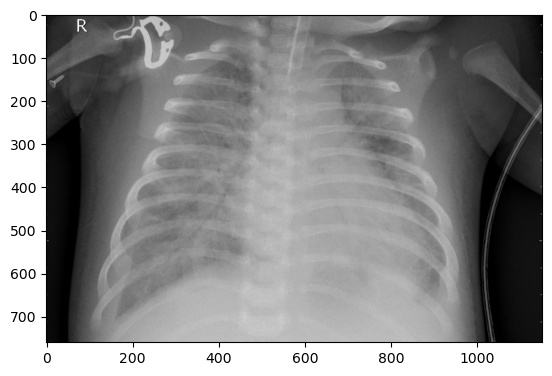

In [17]:
lung_image = load_img("data/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg ")

print("Pneumonia")
plt.imshow(lung_image)
plt.show()

### Data with preprocessing/image manipulation

In [7]:
#Mix few normal and infected lung images.

datasets , pneumonia_lung, normal_lung = ['train', 'test', 'val'],  [], []

for i in datasets:
    path = os.path.join(directory,i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print(len(pneumonia_lung))
print(len(normal_lung))

4273
1583


In [8]:
#shuffle the images
random.shuffle(normal_lung)
random.shuffle((pneumonia_lung))

images = normal_lung[:50] + pneumonia_lung[:50]
images[:5]

['data/chest_xray/train\\NORMAL\\NORMAL2-IM-0687-0001.jpeg',
 'data/chest_xray/train\\NORMAL\\IM-0551-0001-0002.jpeg',
 'data/chest_xray/train\\NORMAL\\NORMAL2-IM-1350-0001.jpeg',
 'data/chest_xray/train\\NORMAL\\NORMAL2-IM-1100-0001.jpeg',
 'data/chest_xray/train\\NORMAL\\NORMAL2-IM-1252-0001.jpeg']

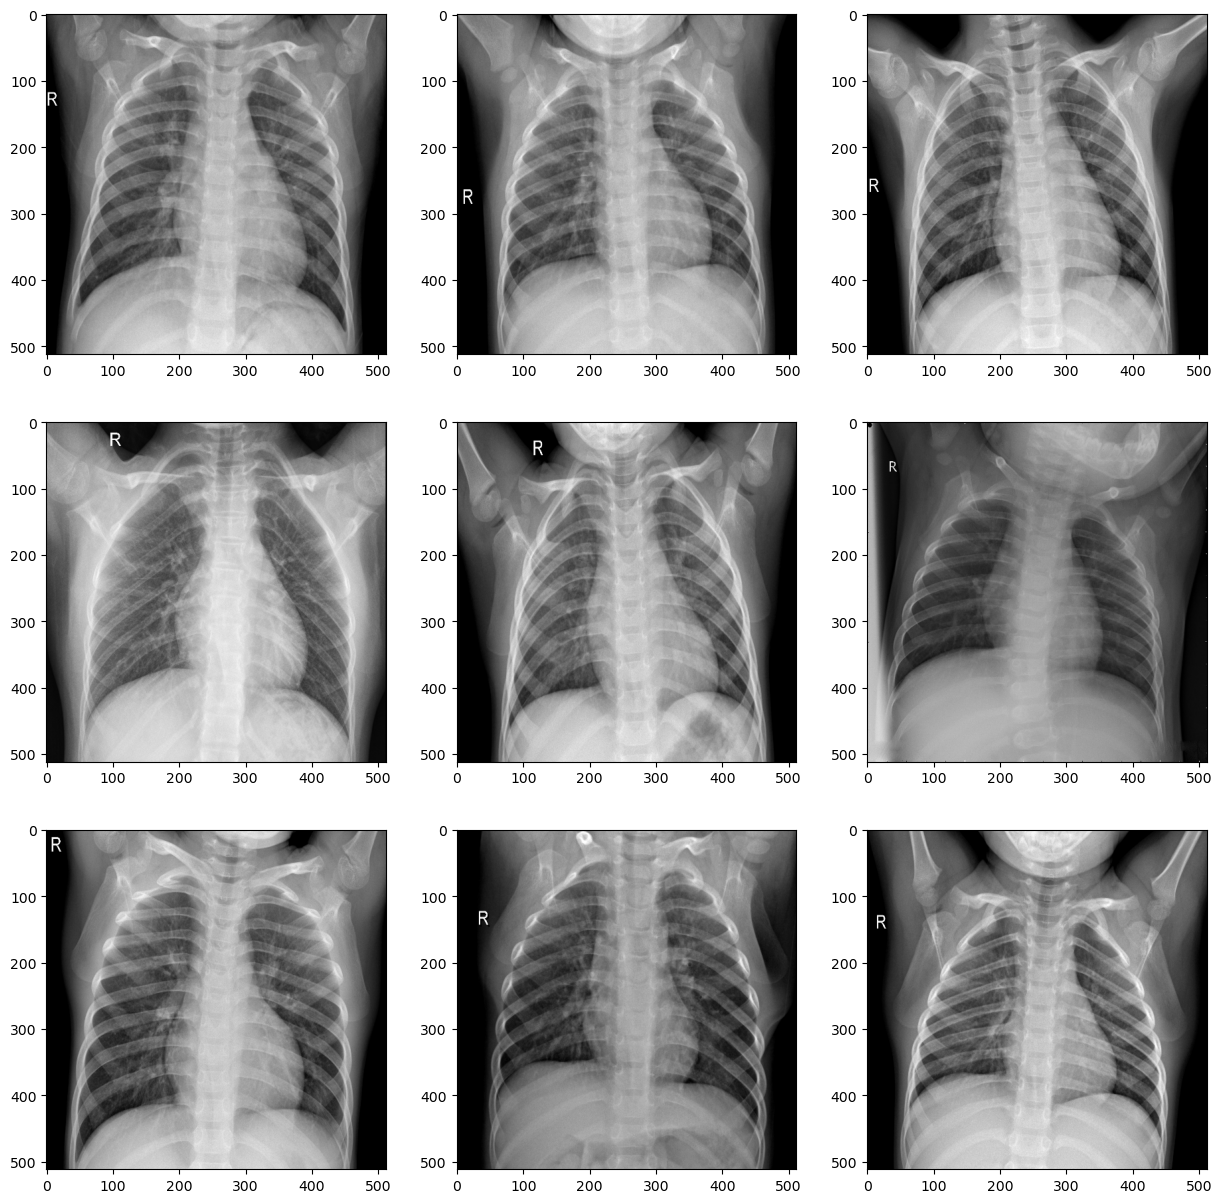

In [9]:

fig = plt.figure(figsize=(15,15))
columns, rows = 3,3
for i in range(1,10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

### Convert image to grayscale and apply gaussian blur


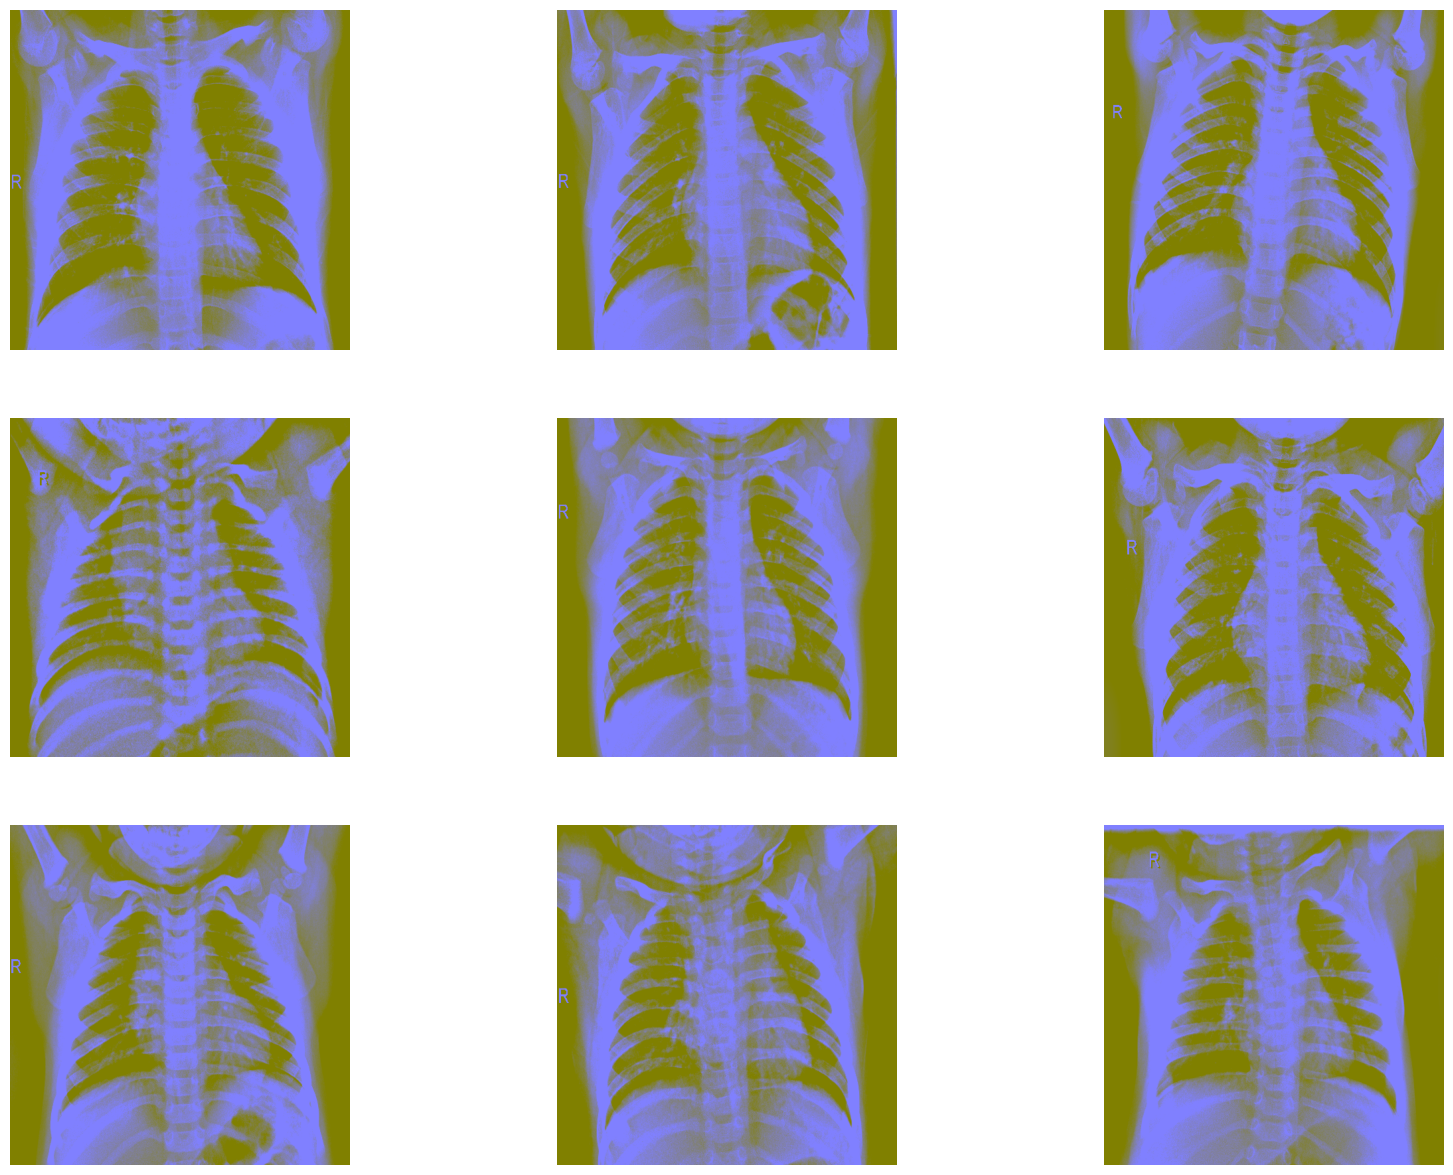

In [21]:
fig = plt.figure(figsize=
                 (20,15))
columns, rows = 3,3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

# Deep Learning Model

In [10]:
train_dir = "data/chest_xray/train"
test_dir = "data/chest_xray/test"
validation_dir = "data/chest_xray/val"

In [11]:
%%time

train_datagen = ImageDataGenerator(
                rescale = 1/255.,
                horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 0.3,
    zca_whitening = True,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    channel_shift_range = 0.25,
    shear_range = 0.2,
    zoom_range = 0.4
    )

val_test_datagen = ImageDataGenerator(rescale = 1./255)
train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

Found 5216 images belonging to 2 classes.


J:\C\Anaconda\envs\portfolio\lib\site-packages\keras\preprocessing\image.py:1447: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  "This ImageDataGenerator specifies "


Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Wall time: 479 ms


## Building a CNN Model

In [27]:
model1 = Sequential()

#Adding layers to Sequential model
#Block One
model1.add(Conv2D(32, (3,3), strides = (1,1), activation = 'relu', padding = 'same', input_shape = (224, 224,3)))
model1.add(MaxPooling2D(pool_size = (2,2)))

#Block Two
model1.add(Conv2D(64, (3,3), strides=(1,1), activation = 'relu', padding='same'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))

#Block Three
model1.add(Conv2D(128, (3,3), strides = (1,1), activation='relu', padding='same'))
model1.add(MaxPooling2D(pool_size = (2,2)))

#Block Four
model1.add(Conv2D(256, (3,3), strides = (1,1), activation='relu', padding='same'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))
model1.add(Flatten())


#Fully connected layers
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       7

In [28]:
# compile the model
model1.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In [29]:
early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)

In [30]:
%%time

history = model1.fit(train_set,
                               epochs=20,
                               validation_data=validation_set,
                               steps_per_epoch=100,
                               callbacks=[early_stopping_callbacks]
                               )

J:\C\Anaconda\envs\portfolio\lib\site-packages\keras\preprocessing\image.py:1864: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

J:\C\Anaconda\envs\portfolio\lib\site-packages\keras\preprocessing\image.py:1887: UserWarning:

This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Epoch 1/20
100/100 [==============================] - 32s 305ms/step - loss: 0.5253 - accuracy: 0.7444 - val_loss: 0.6420 - val_accuracy: 0.5625
Epoch 2/20
100/100 [==============================] - 29s 292ms/step - loss: 0.4259 - accuracy: 0.7744 - val_loss: 0.6366 - val_accuracy: 0.6250
Epoch 3/20
100/100 [==============================] - 29s 289ms/step - loss: 0.4234 - accuracy: 0.7937 - val_loss: 1.1167 - val_accuracy: 0.6250
Epoch 4/20
100/100 [==============================] - 29s 294ms/step - loss: 0.3982 - accuracy: 0.8181 - val_loss: 0.8056 - val_accuracy: 0.6250
Epoch 5/20
100/100 [==============================] - 29s 290ms/step - loss: 0.3454 - accuracy: 0.8444 - val_loss: 0.9526 - val_accuracy: 0.6250
Epoch 6/20
100/100 [==============================] - 29s 288ms/step - loss: 0.3090 - accuracy: 0.8569 - val_loss: 1.6453 - val_accuracy: 0.6250
Epoch 7/20
100/100 [==============================] - 29s 288ms/step - loss: 0.3211 - accuracy: 0.8575 - val_loss: 0.5592 - val_ac

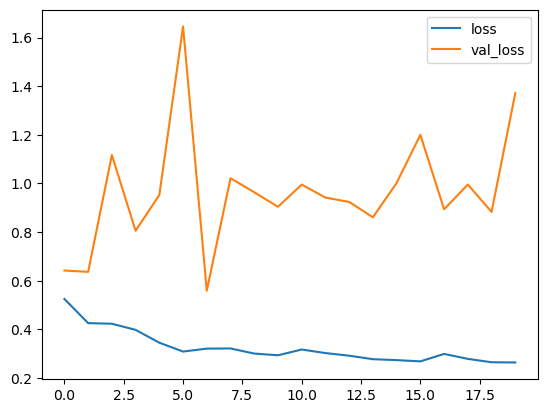

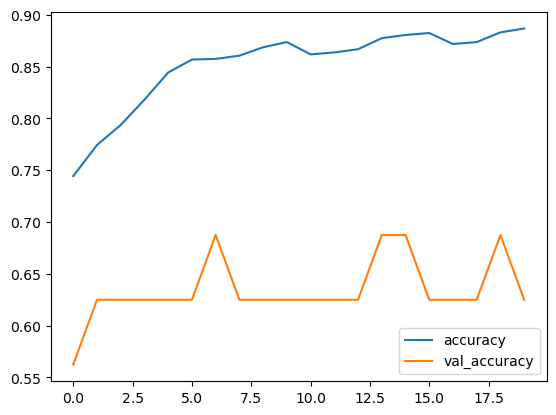

In [31]:
# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

## Model 2

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

model2 = keras.Sequential([
    layers.InputLayer(input_shape=[224, 224, 3]),

    # Data Augmentation
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
model2.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics =['accuracy']
)

early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(
    patience=15,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
%%time

history2 = model2.fit(
    train_set,
    epochs=20,
    validation_data= validation_set,
    steps_per_epoch=100,
    callbacks= [early_stopping_callbacks])


In [ ]:
import pandas as pd
def plotdiagram(model):
    history_frame = pd.DataFrame(model.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

## Transfer Learning

### VGG16

In [ ]:
base_model1 = VGG16(include_top = False, weights = 'imagenet', input_shape=(224,224,3),
                    pooling = 'max', classes = 2)

base_model1.summary()

In [ ]:
model3  = Sequential()
model3.add(base_model1)
model3.add(Flatten())

model3.add(Dense(128, activation = 'relu'))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))

for layer in base_model1.layers:
    layer.trainable = False

model3.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In [ ]:
%%time

history3 = model3.fit(train_set,
                      epochs = 20,
                      validation_data = validation_set,
                      steps_per_epoch = 100,
                      callbacks = [early_stopping_callbacks])

In [ ]:
plotdiagram(history3)

#### Evaluate model on Test Dataset

In [32]:
def evaluate_model(modelX):
    test_loss, test_accuracy = modelX.evaluate(test_set, steps = 50)
    print("The testing accuracy is : ", test_accuracy * 100, '%')
    print("The testing loss is: ", test_loss * 100, '%')

In [ ]:
evaluate_model(model3)

In [33]:
evaluate_model(model1)

50/50 [==============================] - 6s 110ms/step - loss: 0.4871 - accuracy: 0.7997
The testing accuracy is :  79.96794581413269 %
The testing loss is:  48.705703020095825 %


In [ ]:
evaluate_model(model2)

# ResNet50V2 model

In [ ]:
base_model2 = tensorflow.keras.applications.ResNet50V2(weights='imagenet',
                                                       input_shape=(224,224,3),
                                                       include_top= False,
                                                       pooling = "max",
                                                       classes = 2)




In [ ]:
model_resnet = Sequential()
model_resnet.add(base_model2)
model_resnet.add(Flatten())

model_resnet.add(Dense(128, activation = 'relu'))
model_resnet.add(Dense(64, activation = 'relu'))
model_resnet.add(Dense(32, activation = 'relu'))
model_resnet.add(Dense(1, activation = 'sigmoid'))

for layer in base_model2.layers:
    layer.trainable = False

model_resnet.compile(optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

In [ ]:
pip install -U tensorflow-addons

In [ ]:
%%time
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()

history_resnet = model_resnet.fit(train_set,
                                  epochs = 20,
                                  validation_data = validation_set,
                                  steps_per_epoch = 100,
                                  callbacks = [early_stopping_callbacks, tqdm_callback])

In [ ]:
plotdiagram(history_resnet)

In [ ]:
evaluate_model(model_resnet)

In [12]:
log_df = pd.read_csv("data/model_logs.csv")

In [13]:
log_df

,Model Name,Accuracy,Val_Accuracy,Loss,Val_Loss,Testing_Accuracy,Testing_Loss
0,Model 1,0.88,0.62,0.26,1.82,84.93,41.90
1,Model 2,0.74,0.50,0.56,0.78,62.50,67.73
2,Model Vgg,0.91,0.75,0.23,0.94,71.47,53.44
3,Model Resnet,0.92,0.87,0.17,0.27,90.06,24.92


### Predict Result

In [ ]:
img_path = "data/chest_xray/predict/n4.jpeg"
test_img = image.load_img(img_path, target_size = (224,224))
test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)

#normalize the image
test_img = test_img/255.

prediction = model_resnet.predict(test_img)
print(prediction)
train_set.class_indices
if prediction[0][0] == 0:
    result = "Normal lung"
else:
    result = "Pneumonia Lung"

print(result)

## Save the Model

In [ ]:
model_resnet.save("model_resnet_pneumonia_detection.h5")

In [14]:
# Load and predict the using the model

def image_prediction(new_image_path):
    test_image = image.load_img(new_image_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    #test_image = np.reshape(test_image, (224, 224, 3))
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = test_image / 255.0
    model_loaded = tensorflow.keras.models.load_model("model_resnet_pneumonia_detection.h5")
    prediction = model_loaded.predict(test_image)
    test_image_for_plotting = image.load_img(new_image_path, target_size = (224, 224))
    plt.imshow(test_image_for_plotting)
    if(prediction[0] > 0.5):
        statistic = prediction[0] * 100
        print("This image is %.3f percent %s"% (statistic, "P N E U M O N I A"))
    else:
        statistic = (1.0 - prediction[0]) * 100
        print("This image is %.3f percent %s" % (statistic, "N O R M A L"))

1/1 [==============================] - 1s 616ms/step
This image is 97.774 percent N O R M A L


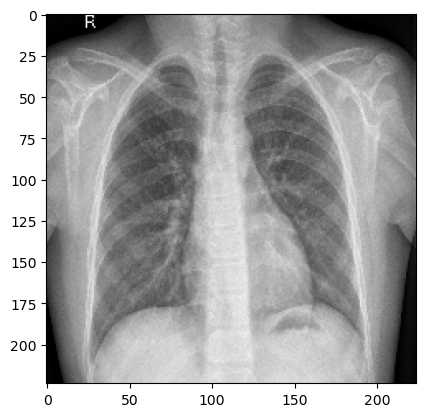

In [36]:
image_prediction("data/chest_xray/predict/n.jpeg")

## Predict on Test set

In [15]:
test_dir = "data/chest_xray/test"
test_data, test_labels = [],[]
model_loaded = tensorflow.keras.models.load_model("model_resnet_pneumonia_detection.h5")

In [16]:
for i in ["/NORMAL/", "/PNEUMONIA/"]:
    for image in (os.listdir(test_dir + i)):
        image = plt.imread(test_dir + i + image)
        image = cv2.resize(image, (224, 224))
        image = np.dstack([image, image, image])
        image = image.astype("float32") / 255
        if i == "/NORMAL/":
            label = 0
        elif i == "/PNEUMONIA/":
            label = 1
        test_data.append(image)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [19]:
pip install mlxtend

     ---------------------------------------- 1.3/1.3 MB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot
from mlxtend.plotting import plot_confusion_matrix

_______C o n f u s i o n   m a t r i x_______

20/20 [==============================] - 1s 75ms/step


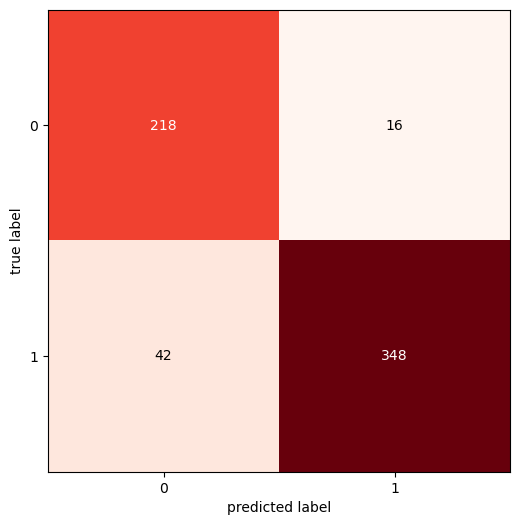

In [21]:
print("_______C o n f u s i o n   m a t r i x_______\n")

predictions = model_loaded.predict(test_data)
conf_m = confusion_matrix(test_labels, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = matplotlib.pyplot.cm.Reds)
plt.show()

In [22]:
%%time

precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))

Accuracy: 90.7051282051282%
Precision: 95.6043956043956%
Recall: 89.23076923076924%
F1-score: 92.3076923076923
Wall time: 500 µs


In [23]:
predictions = list()
preds = model_loaded.predict(test_data)
for i in preds:
    if i >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
predictions[:15]

20/20 [==============================] - 2s 79ms/step


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [24]:
correct_predictions = np.nonzero(predictions == test_labels)[0]
incorrect_predictions = np.nonzero(predictions != test_labels)[0]

# let's look at indices of correct predictions
print("Indices of correct predictions:\n", correct_predictions[:15])

# let's look at indices of incorrect correct predictions
print("\nIndices of incorrect predictions:\n", incorrect_predictions[:15])

Indices of correct predictions:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Indices of incorrect predictions:
 [ 45 119 121 122 123 124 126 129 131 132 133 134 140 143 144]


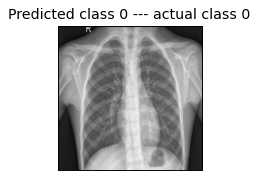

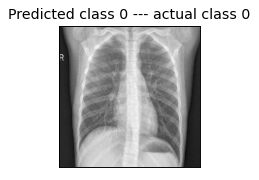

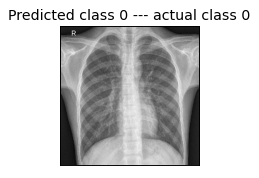

In [25]:
# display correct predictions

i = 0
for a in correct_predictions[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1

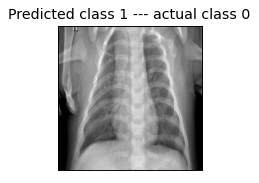

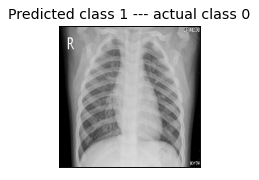

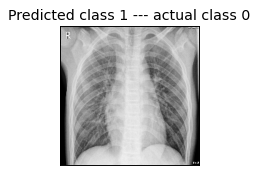

In [26]:
# display incorrect predictions

i = 0
for a in incorrect_predictions[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1